# Football Object Detection with Tactical Map Position Estimation

In [7]:
# Import libraries
import numpy as np
import pandas as pd

import cv2
import skimage
from PIL import Image
from ultralytics import YOLO
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

import json
import yaml
import time


pip install skimage


In [8]:
%pip install scikit-image


Note: you may need to restart the kernel to use updated packages.


In [9]:
# Load configurations and models
json_path = r"D:\AI platoform fo rvisual cognative impared\New folder\Football-Analytics-with-Deep-Learning-and-Computer-Vision\pitch map labels position.json"
with open(json_path, 'r') as f:
    keypoints_map_pos = json.load(f)

yaml_path = r"D:\AI platoform fo rvisual cognative impared\New folder\Football-Analytics-with-Deep-Learning-and-Computer-Vision\config pitch dataset.yaml"
with open(yaml_path, 'r') as file:
    classes_names_dic = yaml.safe_load(file)
classes_names_dic = classes_names_dic['names']

yaml_path = r"D:\AI platoform fo rvisual cognative impared\New folder\Football-Analytics-with-Deep-Learning-and-Computer-Vision\config players dataset.yaml"
with open(yaml_path, 'r') as file:
    labels_dic = yaml.safe_load(file)
labels_dic = labels_dic['names']

print("Known coordinates of each keypoint on the tactical map:")
display(pd.DataFrame(keypoints_map_pos, index=['x','y']))
print("Numerical label of field keypoints (as defined when training the Yolo model):")
display(pd.Series(classes_names_dic, name='alpha_label').reset_index().rename({"index":"num_label"}, axis=1).set_index("alpha_label").transpose())
print("Numerical label of the player, referee, and ball objects (as defined when training the Yolo model):")
display(pd.Series(labels_dic, name='alpha_label').reset_index().rename({"index":"num_label"}, axis=1).set_index("alpha_label").transpose())
print('\033[1mThe dataframe representation are not used in what follows (original dictionary will be used)')

Known coordinates of each keypoint on the tactical map:


,TLC,TRC,TR6MC,TL6MC,TR6ML,TL6ML,TR18MC,TL18MC,TR18ML,TL18ML,...,BR6MC,BL6MC,BR6ML,BL6ML,BR18MC,BL18MC,BR18ML,BL18ML,BRArc,BLArc
x,20,276,204,100,205,100,246,69,246,69,...,205,100,205,100,246,69,246,69,197,112
y,20,20,40,40,20,20,88,88,20,20,...,486,486,496,496,448,448,496,496,448,448


Numerical label of field keypoints (as defined when training the Yolo model):


alpha_label,TLC,TRC,TR6MC,TL6MC,TR6ML,TL6ML,TR18MC,TL18MC,TR18ML,TL18ML,...,BR6MC,BL6MC,BR6ML,BL6ML,BR18MC,BL18MC,BR18ML,BL18ML,BRArc,BLArc
num_label,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27


Numerical label of the player, referee, and ball objects (as defined when training the Yolo model):


alpha_label,player,referee,ball
num_label,0,1,2


The dataframe representation are not used in what follows (original dictionary will be used)


In [10]:
# Set video path
video_path = r'D:\AI platoform fo rvisual cognative impared\New folder\Football-Analytics-with-Deep-Learning-and-Computer-Vision\test-vid_m2GKv17c.mp4'

# Read tactical map image
tac_map = cv2.imread(r'D:\AI platoform fo rvisual cognative impared\New folder\Football-Analytics-with-Deep-Learning-and-Computer-Vision\tactical map.jpg')

# Define team colors (based on chosen video)
nbr_team_colors = 2
colors_dic = {
    "Chelsea":[(41,71,138), (220,98,88)], # Chelsea colors (Players kit color, GK kit color)
    "Man City":[(144,200,255), (188,199,3)] # Man City colors (Players kit color, GK kit color)
}

colors_list = colors_dic["Chelsea"]+colors_dic["Man City"] # Define color list to be used for detected player team prediction
color_list_lab = [skimage.color.rgb2lab([i/255 for i in c]) for c in colors_list] # Converting color_list to L*a*b* space

In [11]:
model_players = YOLO(r"D:\AI platoform fo rvisual cognative impared\New folder\Football-Analytics-with-Deep-Learning-and-Computer-Vision\models\Yolo8L Players\weights\best.pt")
model_keypoints = YOLO(r"D:\AI platoform fo rvisual cognative impared\New folder\Football-Analytics-with-Deep-Learning-and-Computer-Vision\models\Yolo8M Field Keypoints\weights\best.pt")


In [12]:
# Open video file
cap = cv2.VideoCapture(video_path)

# Initialize frame counter
frame_nbr = 0

# Set keypoints average displacement tolerance level (in pixels) [set to -1 to always update homography matrix]
keypoints_displacement_mean_tol = 10

# Set confidence thresholds for players and field keypoints detections
player_model_conf_thresh = 0.60
keypoints_model_conf_thresh = 0.70

# Set variable to record the time when we processed last frame 
prev_frame_time = 0
# Set variable to record the time at which we processed current frame 
new_frame_time = 0

# Store the ball track history
ball_track_history = {'src':[],
                      'dst':[]
}

# Count consecutive frames with no ball detected
nbr_frames_no_ball = 0
# Threshold for number of frames with no ball to reset ball track (frames)
nbr_frames_no_ball_thresh = 30
# Distance threshold for ball tracking (pixels)
ball_track_dist_thresh = 100
# Maximum ball track length (detections)
max_track_length = 35

# Loop through the video frames
while cap.isOpened():

    # Update frame counter
    frame_nbr += 1

    # Read a frame from the video
    success, frame = cap.read()

    # Reset tactical map image for each new frame
    tac_map_copy = tac_map.copy()

    # Reset ball tracks
    if nbr_frames_no_ball>nbr_frames_no_ball_thresh:
            ball_track_history['dst'] = []
            ball_track_history['src'] = []

    # Process the frame if it was successfuly read
    if success:
        
        #################### Part 1 ####################
        # Object Detection & Coordiante Transofrmation #
        ################################################

        # Run YOLOv8 players inference on the frame
        results_players = model_players(frame, conf=player_model_conf_thresh)
        # Run YOLOv8 field keypoints inference on the frame
        results_keypoints = model_keypoints(frame, conf=keypoints_model_conf_thresh)

        ## Extract detections information
        bboxes_p = results_players[0].boxes.xyxy.cpu().numpy()                          # Detected players, referees and ball (x,y,x,y) bounding boxes
        bboxes_p_c = results_players[0].boxes.xywh.cpu().numpy()                        # Detected players, referees and ball (x,y,w,h) bounding boxes    
        labels_p = list(results_players[0].boxes.cls.cpu().numpy())                     # Detected players, referees and ball labels list
        confs_p = list(results_players[0].boxes.conf.cpu().numpy())                     # Detected players, referees and ball confidence level
        
        bboxes_k = results_keypoints[0].boxes.xyxy.cpu().numpy()                        # Detected field keypoints (x,y,w,h) bounding boxes
        bboxes_k_c = results_keypoints[0].boxes.xywh.cpu().numpy()                        # Detected field keypoints (x,y,w,h) bounding boxes
        labels_k = list(results_keypoints[0].boxes.cls.cpu().numpy())                   # Detected field keypoints labels list

        # Convert detected numerical labels to alphabetical labels
        detected_labels = [classes_names_dic[i] for i in labels_k]

        # Extract detected field keypoints coordiantes on the current frame
        detected_labels_src_pts = np.array([list(np.round(bboxes_k_c[i][:2]).astype(int)) for i in range(bboxes_k_c.shape[0])])

        # Get the detected field keypoints coordinates on the tactical map
        detected_labels_dst_pts = np.array([keypoints_map_pos[i] for i in detected_labels])


        ## Calculate Homography transformation matrix when more than 4 keypoints are detected
        if len(detected_labels) > 3:
            # Always calculate homography matrix on the first frame
            if frame_nbr > 1:
                # Determine common detected field keypoints between previous and current frames
                common_labels = set(detected_labels_prev) & set(detected_labels)
                # When at least 4 common keypoints are detected, determine if they are displaced on average beyond a certain tolerance level
                if len(common_labels) > 3:
                    common_label_idx_prev = [detected_labels_prev.index(i) for i in common_labels]   # Get labels indexes of common detected keypoints from previous frame
                    common_label_idx_curr = [detected_labels.index(i) for i in common_labels]        # Get labels indexes of common detected keypoints from current frame
                    coor_common_label_prev = detected_labels_src_pts_prev[common_label_idx_prev]     # Get labels coordiantes of common detected keypoints from previous frame
                    coor_common_label_curr = detected_labels_src_pts[common_label_idx_curr]          # Get labels coordiantes of common detected keypoints from current frame
                    coor_error = mean_squared_error(coor_common_label_prev, coor_common_label_curr)  # Calculate error between previous and current common keypoints coordinates
                    update_homography = coor_error > keypoints_displacement_mean_tol                 # Check if error surpassed the predefined tolerance level
                else:
                    update_homography = True                                                         
            else:
                update_homography = True

            if  update_homography:
                h, mask = cv2.findHomography(detected_labels_src_pts,                   # Calculate homography matrix
                                              detected_labels_dst_pts)                  
            
            detected_labels_prev = detected_labels.copy()                               # Save current detected keypoint labels for next frame
            detected_labels_src_pts_prev = detected_labels_src_pts.copy()               # Save current detected keypoint coordiantes for next frame

            bboxes_p_c_0 = bboxes_p_c[[i==0 for i in labels_p],:]                       # Get bounding boxes information (x,y,w,h) of detected players (label 0)
            bboxes_p_c_2 = bboxes_p_c[[i==2 for i in labels_p],:]                       # Get bounding boxes information (x,y,w,h) of detected ball(s) (label 2)

            # Get coordinates of detected players on frame (x_cencter, y_center+h/2)
            detected_ppos_src_pts = bboxes_p_c_0[:,:2]  + np.array([[0]*bboxes_p_c_0.shape[0], bboxes_p_c_0[:,3]/2]).transpose()
            # Get coordinates of the first detected ball (x_center, y_center)
            detected_ball_src_pos = bboxes_p_c_2[0,:2] if bboxes_p_c_2.shape[0]>0 else None

            # Transform players coordinates from frame plane to tactical map plance using the calculated Homography matrix
            pred_dst_pts = []                                                           # Initialize players tactical map coordiantes list
            for pt in detected_ppos_src_pts:                                            # Loop over players frame coordiantes
                pt = np.append(np.array(pt), np.array([1]), axis=0)                     # Covert to homogeneous coordiantes
                dest_point = np.matmul(h, np.transpose(pt))                              # Apply homography transofrmation
                dest_point = dest_point/dest_point[2]                                   # Revert to 2D-coordiantes
                pred_dst_pts.append(list(np.transpose(dest_point)[:2]))                 # Update players tactical map coordiantes list
            pred_dst_pts = np.array(pred_dst_pts)

            # Transform ball coordinates from frame plane to tactical map plane using the calculated Homography matrix
            if detected_ball_src_pos is not None:
                pt = np.append(np.array(detected_ball_src_pos), np.array([1]), axis=0)
                dest_point = np.matmul(h, np.transpose(pt))
                dest_point = dest_point/dest_point[2]
                detected_ball_dst_pos = np.transpose(dest_point)

                # Update track ball position history
                if len(ball_track_history['src'])>0 :
                    if np.linalg.norm(detected_ball_src_pos-ball_track_history['src'][-1])<ball_track_dist_thresh:
                        ball_track_history['src'].append((int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1])))
                        ball_track_history['dst'].append((int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1])))
                    else:
                        ball_track_history['src']=[(int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1]))]
                        ball_track_history['dst']=[(int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1]))]
                else:
                    ball_track_history['src'].append((int(detected_ball_src_pos[0]), int(detected_ball_src_pos[1])))
                    ball_track_history['dst'].append((int(detected_ball_dst_pos[0]), int(detected_ball_dst_pos[1])))
            # Remove oldest tracked ball postion if track exceedes threshold        
            if len(ball_track_history) > max_track_length:
                    ball_track_history['src'].pop(0)
                    ball_track_history['dst'].pop(0)

        ######### Part 2 ########## 
        # Players Team Prediction #
        ###########################

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)                                      # Convert frame to RGB
        obj_palette_list = []                                                                   # Initialize players color palette list
        palette_interval = (0,5)                                                                # Color interval to extract from dominant colors palette (1rd to 5th color)
        annotated_frame = frame                                                                 # Create annotated frame 

        ## Loop over detected players (label 0) and extract dominant colors palette based on defined interval
        for i, j in enumerate(list(results_players[0].boxes.cls.cpu().numpy())):
            if int(j) == 0:
                bbox = results_players[0].boxes.xyxy.cpu().numpy()[i,:]                         # Get bbox info (x,y,x,y)
                obj_img = frame_rgb[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]       # Crop bbox out of the frame
                obj_img_w, obj_img_h = obj_img.shape[1], obj_img.shape[0]
                center_filter_x1 = np.max([(obj_img_w//2)-(obj_img_w//5), 1])
                center_filter_x2 = (obj_img_w//2)+(obj_img_w//5)
                center_filter_y1 = np.max([(obj_img_h//3)-(obj_img_h//5), 1])
                center_filter_y2 = (obj_img_h//3)+(obj_img_h//5)
                center_filter = obj_img[center_filter_y1:center_filter_y2, 
                                        center_filter_x1:center_filter_x2]
                obj_pil_img = Image.fromarray(np.uint8(center_filter))                          # Convert to pillow image
                    
                reduced = obj_pil_img.convert("P", palette=Image.Palette.WEB)                   # Convert to web palette (216 colors)
                palette = reduced.getpalette()                                                  # Get palette as [r,g,b,r,g,b,...]
                palette = [palette[3*n:3*n+3] for n in range(256)]                              # Group 3 by 3 = [[r,g,b],[r,g,b],...]
                color_count = [(n, palette[m]) for n,m in reduced.getcolors()]                  # Create list of palette colors with their frequency
                RGB_df = pd.DataFrame(color_count, columns = ['cnt', 'RGB']).sort_values(       # Create dataframe based on defined palette interval
                                      by = 'cnt', ascending = False).iloc[
                                          palette_interval[0]:palette_interval[1],:]
                palette = list(RGB_df.RGB)                                                      # Convert palette to list (for faster processing)
                annotated_frame = cv2.rectangle(annotated_frame,                                # Add center filter bbox annotations
                                                (int(bbox[0])+center_filter_x1, 
                                                 int(bbox[1])+ center_filter_y1),  
                                                (int(bbox[0])+center_filter_x2, 
                                                 int(bbox[1])+center_filter_y2), (0,0,0), 2)
                
                # Update detected players color palette list
                obj_palette_list.append(palette)
        
        ## Calculate distances between each color from every detected player color palette and the predefined teams colors
        players_distance_features = []
        # Loop over detected players extracted color palettes
        for palette in obj_palette_list:
            palette_distance = []
            palette_lab = [skimage.color.rgb2lab([i/255 for i in color]) for color in palette]  # Convert colors to L*a*b* space
            # Loop over colors in palette
            for color in palette_lab:
                distance_list = []
                # Loop over predefined list of teams colors
                for c in color_list_lab:
                    #distance = np.linalg.norm([i/255 - j/255 for i,j in zip(color,c)])
                    distance = skimage.color.deltaE_cie76(color, c)                             # Calculate Euclidean distance in Lab color space
                    distance_list.append(distance)                                              # Update distance list for current color
                palette_distance.append(distance_list)                                          # Update distance list for current palette
            players_distance_features.append(palette_distance)                                  # Update distance features list

        ## Predict detected players teams based on distance features
        players_teams_list = []
        # Loop over players distance features
        for distance_feats in players_distance_features:
            vote_list=[]
            # Loop over distances for each color 
            for dist_list in distance_feats:
                team_idx = dist_list.index(min(dist_list))//nbr_team_colors                     # Assign team index for current color based on min distance
                vote_list.append(team_idx)                                                      # Update vote voting list with current color team prediction
            players_teams_list.append(max(vote_list, key=vote_list.count))                      # Predict current player team by vote counting


        #################### Part 3 #####################
        # Updated Frame & Tactical Map With Annotations #
        #################################################

        ball_color_bgr = (0,0,255)                                                                          # Color (GBR) for ball annotation on tactical map
        j=0                                                                                                 # Initializing counter of detected players
        palette_box_size = 10                                                                               # Set color box size in pixels (for display)
        

        # Loop over all detected object by players detection model
        for i in range(bboxes_p.shape[0]):
            conf = confs_p[i]                                                                               # Get confidence of current detected object
            if labels_p[i]==0:                                                                              # Display annotation for detected players (label 0)
                
                # Display extracted color palette for each detected player
                palette = obj_palette_list[j]                                                               # Get color palette of the detected player
                for k, c in enumerate(palette):
                    c_bgr = c[::-1]                                                                         # Convert color to BGR
                    annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,2])+3,                 # Add color palette annotation on frame
                                                            int(bboxes_p[i,1])+k*palette_box_size),
                                                            (int(bboxes_p[i,2])+palette_box_size,
                                                            int(bboxes_p[i,1])+(palette_box_size)*(k+1)),
                                                              c_bgr, -1)

                team_name = list(colors_dic.keys())[players_teams_list[j]]                                  # Get detected player team prediction
                color_rgb = colors_dic[team_name][0]                                                        # Get detected player team color
                color_bgr = color_rgb[::-1]                                                                 # Convert color to bgr

                annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,0]), int(bboxes_p[i,1])),  # Add bbox annotations with team colors
                                                (int(bboxes_p[i,2]), int(bboxes_p[i,3])), color_bgr, 1)
                
                cv2.putText(annotated_frame, team_name + f" {conf:.2f}",                                    # Add team name annotations
                             (int(bboxes_p[i,0]), int(bboxes_p[i,1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                               color_bgr, 2)
                
                # Add tactical map player postion color coded annotation if more than 3 field keypoints are detected
                if len(detected_labels_src_pts)>3:
                    tac_map_copy = cv2.circle(tac_map_copy, (int(pred_dst_pts[j][0]),int(pred_dst_pts[j][1])),
                                          radius=5, color=color_bgr, thickness=-1)

                j+=1                                                                                        # Update players counter
            else:                                                                                           # Display annotation for otehr detections (label 1, 2)
                annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_p[i,0]), int(bboxes_p[i,1])),  # Add white colored bbox annotations
                                                 (int(bboxes_p[i,2]), int(bboxes_p[i,3])), (255,255,255), 1)
                cv2.putText(annotated_frame, labels_dic[labels_p[i]] + f" {conf:.2f}",                      # Add white colored label text annotations
                            (int(bboxes_p[i,0]), int(bboxes_p[i,1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                              (255,255,255), 2)

                # Add tactical map ball postion annotation if detected
                if detected_ball_src_pos is not None:
                    tac_map_copy = cv2.circle(tac_map_copy, (int(detected_ball_dst_pos[0]), 
                                                   int(detected_ball_dst_pos[1])), radius=5, 
                                                   color=ball_color_bgr, thickness=3)
        for i in range(bboxes_k.shape[0]):
            annotated_frame = cv2.rectangle(annotated_frame, (int(bboxes_k[i,0]), int(bboxes_k[i,1])),  # Add bbox annotations with team colors
                                        (int(bboxes_k[i,2]), int(bboxes_k[i,3])), (0,0,0), 1)
        
        # Plot the ball tracks on tactical map
        if len(ball_track_history['src'])>0:
            points = np.hstack(ball_track_history['dst']).astype(np.int32).reshape((-1, 1, 2))
            tac_map_copy = cv2.polylines(tac_map_copy, [points], isClosed=False, color=(0, 0, 100), thickness=2)
        
        # Combine annotated frame and tactical map in one image with colored border separation
        border_color = [255,255,255]                                                                        # Set border color (BGR)
        annotated_frame=cv2.copyMakeBorder(annotated_frame, 40, 10, 10, 10,                                 # Add borders to annotated frame
                                            cv2.BORDER_CONSTANT, value=border_color)
        tac_map_copy = cv2.copyMakeBorder(tac_map_copy, 70, 50, 10, 10, cv2.BORDER_CONSTANT,                # Add borders to tactical map 
                                           value=border_color)      
        tac_map_copy = cv2.resize(tac_map_copy, (tac_map_copy.shape[1], annotated_frame.shape[0]))          # Resize tactical map
        final_img = cv2.hconcat((annotated_frame, tac_map_copy))                                            # Concatenate both images
        ## Add info annotation
        cv2.putText(final_img, "Tactical Map", (1370,60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)
        cv2.putText(final_img, "Press 'p' to pause & 'q' to quit", (820,30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)

        new_frame_time = time.time()                                                                        # Get time after finished processing current frame
        fps = 1/(new_frame_time-prev_frame_time)                                                            # Calculate FPS as 1/(frame proceesing duration)
        prev_frame_time = new_frame_time                                                                    # Save current time to be used in next frame
        cv2.putText(final_img, "FPS: " + str(int(fps)), (20,30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)
        
        # Display the final annotated frame
        cv2.imshow("YOLOv8 Players and Field Keypoints Detection with Team Prediction and Tactical Map",final_img)

        # Treat keyboard user inputs ("p" for pause/unpause & "q" for quit)
        key = cv2.waitKey(1)
        # Break the loop if 'q' is pressed
        if key == ord("q"):
            break
        if key == ord('p'):
            cv2.waitKey(-1) #wait until any key is pressed
    else:
        # Break the loop if the end of the video is reached
        break
# ... (rest of the code remains the same)

# Initialize frame counter
frame_nbr = 0

# ... (rest of the code remains the same)

while cap.isOpened():
    # Update frame counter
    frame_nbr += 1

    # ... (rest of the code remains the same)

    if success:
        # ... (rest of the code remains the same)

        # Update tactical map every 10 frames
        if frame_nbr % 10 == 0:
            tac_map_copy = tac_map.copy()

        # ... (rest of the code remains the same)

        # Draw a line connecting the same player's dots to visualize their formation
        if len(pred_dst_pts) > 1:
            for i in range(len(pred_dst_pts) - 1):
                cv2.line(tac_map_copy, (int(pred_dst_pts[i][0]), int(pred_dst_pts[i][1])),
                         (int(pred_dst_pts[i + 1][0]), int(pred_dst_pts[i + 1][1])), (0, 255, 0), 2)

        # ... (rest of the code remains the same)

        # Combine annotated frame and tactical map in one image with colored border separation
        border_color = [255, 255, 255]  # Set border color (BGR)
        annotated_frame = cv2.copyMakeBorder(annotated_frame, 40, 10, 10, 10,
                                            cv2.BORDER_CONSTANT, value=border_color)
        tac_map_copy = cv2.copyMakeBorder(tac_map_copy, 70, 50, 10, 10, cv2.BORDER_CONSTANT,
                                           value=border_color)
        tac_map_copy = cv2.resize(tac_map_copy, (tac_map_copy.shape[1], annotated_frame.shape[0]))
        final_img = cv2.hconcat((annotated_frame, tac_map_copy))

        # ... (rest of the code remains the same)
# Release the video capture object and close the display window

# Replace cv2.imshow() with this
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


0: 384x640 19 players, 1 referee, 1 ball, 376.2ms
Speed: 2.2ms preprocess, 376.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 TLC, 1 TL6MC, 1 TL6ML, 1 TL18MC, 1 TL18ML, 1 TLArc, 1 BL18MC, 186.8ms
Speed: 1.3ms preprocess, 186.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
from PIL import Image

# Load the original image
original_image = Image.open(r"D:\AI platoform fo rvisual cognative impared\New folder\Football-Analytics-with-Deep-Learning-and-Computer-Vision\tactical map 2.jpg")

# Define the new dimensions and DPI
new_width, new_height = 314, 246
new_dpi = 150

# Calculate the scaling factor for resizing
scale_factor_width = new_width / original_image.width
scale_factor_height = new_height / original_image.height

# Resize the image dimensions
resized_image = original_image.resize((new_width, new_height))

# Calculate the new resolution in pixels
new_resolution = (int(new_width * new_dpi / 25.4), int(new_height * new_dpi / 25.4))

# Set the new resolution in the image metadata
resized_image.info['dpi'] = (new_dpi, new_dpi)

# Save the resized image
resized_image.save("resized_image.jpg", dpi=new_resolution, quality=95)


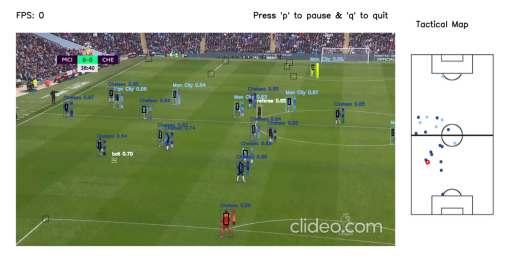

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [ ]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from skimage import color as skimage_color

# Assume the required libraries and models are already imported and initialized

# Replace the code starting from the main while loop to display the image with matplotlib.

# Initialize frame counter
frame_nbr = 0

while cap.isOpened():
    # Update frame counter
    frame_nbr += 1

    # Read the frame from the video capture
    success, frame = cap.read()
    if not success:
        break

    # Your existing processing logic goes here...
    # For example:
    # detected players, ball, etc.
    
    # Assuming `annotated_frame` and `tac_map_copy` are already created.

    # Calculate FPS
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time

    # Combine annotated frame and tactical map in one image with colored border separation
    border_color = [255, 255, 255]  # Set border color (BGR)
    annotated_frame = cv2.copyMakeBorder(annotated_frame, 40, 10, 10, 10,
                                          cv2.BORDER_CONSTANT, value=border_color)
    tac_map_copy = cv2.copyMakeBorder(tac_map_copy, 70, 50, 10, 10, cv2.BORDER_CONSTANT,
                                       value=border_color)
    tac_map_copy = cv2.resize(tac_map_copy, (tac_map_copy.shape[1], annotated_frame.shape[0]))
    final_img = cv2.hconcat((annotated_frame, tac_map_copy))

    # Add info annotation
    cv2.putText(final_img, "Tactical Map", (1370, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
    cv2.putText(final_img, "Press 'p' to pause & 'q' to quit", (820, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
    cv2.putText(final_img, "FPS: " + str(int(fps)), (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)

    # Convert BGR to RGB for displaying with matplotlib
    final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)

    # Display the final annotated frame using matplotlib
    plt.imshow(final_img_rgb)
    plt.axis('off')  # Hide axes
    plt.show(block=False)  # Non-blocking show
    plt.pause(0.001)  # Pause to allow the figure to update

    # Treat keyboard user inputs ("p" for pause/unpause & "q" for quit)
    key = cv2.waitKey(1)
    # Break the loop if 'q' is pressed
    if key == ord("q"):
        break
    if key == ord('p'):
        cv2.waitKey(-1)  # wait until any key is pressed

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


In [ ]:
def remove_double_of_next(numbers):
    result = []
    
    # Iterate over the list except the last element
    for i in range(len(numbers) - 1):
        # Check if the current number is not double of the next number
        
       
       
        if numbers[i + 1] * 2 != numbers[i]:
            result.append(numbers[i])
    

    
    # Append the last element as it has no next number to compare
    

    return result

# Example usage
numbers = [2,4,8]
filtered_numbers = remove_double_of_next(numbers)
print("Filtered numbers:", filtered_numbers)


Filtered numbers: [2, 4]
